In [1]:
import os
from pathlib import Path
import numpy as np
import time
from scipy.optimize import minimize
from simsopt._core.optimizable import load
from simsopt.geo import ArclengthVariation
from simsopt.geo.surfacerzfourier import SurfaceRZFourier
from simsopt.objectives.fluxobjective import SquaredFlux
from simsopt.objectives.utilities import QuadraticPenalty
from simsopt.geo.curve import curves_to_vtk, create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.field.biotsavart import BiotSavart
from simsopt.field.coil import Current, coils_via_symmetries, ScaledCurrent, apply_symmetries_to_curves
from simsopt.geo.curveobjectives import CurveLength, CurveCurveDistance, \
    MeanSquaredCurvature, LpCurveCurvature, CurveSurfaceDistance, LinkingNumber
from simsopt.field.coil import apply_symmetries_to_curves, apply_symmetries_to_currents, Current, Coil, ScaledCurrent

from simsopt.geo import SurfaceSurfaceDistance
from simsopt.field import SurfaceClassifier, \
    particles_to_vtk, compute_fieldlines, LevelsetStoppingCriterion, plot_poincare_data

import matplotlib.pyplot as plt

from simsopt.geo import CurveCWSFourier
from simsopt.geo import Curve2D, OrientedCurveXYZFourier
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

%matplotlib widget

In [8]:
# Number of unique coil shapes, i.e. the number of coils per half field period:
# (Since the configuration has nfp = 2, multiply by 4 to get the total number of coils.)
ncoils = 6

# Major radius for the initial circular coils:
R0 = 1.0

# Minor radius for the initial circular coils:
R1 = 0.5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 7

WP_WEIGHT_SCALE = 1

# Weight on the curve lengths in the objective function. We use the `Weight`
# class here to later easily adjust the scalar value and rerun the optimization
# without having to rebuild the objective.
LENGTH_WEIGHT = 0.0156434465

# Threshold and weight for the coil-to-coil distance penalty in the objective function:
CC_THRESHOLD = 0.08
CC_WEIGHT = 156.434465

# Threshold and weight for the coil-to-surface distance penalty in the objective function:
CS_THRESHOLD = 0.12
CS_WEIGHT = 1564.34465

# Threshold and weight for the curvature penalty in the objective function:
CURVATURE_THRESHOLD = 12.
CURVATURE_WEIGHT = 0.000000156434465

# Threshold and weight for the mean squared curvature penalty in the objective function:
MSC_THRESHOLD = 11
MSC_WEIGHT = 1.10e-08

# Port size relevant weights
wport = 1E-4
wdd = 1E8
#wco = 1E1
#wph = 1E3
warc = 1E-2
wufp = 1E0

# WS weights
ws_weight = 0.0
wp_weight = 1.0

# Number of iterations to perform:
MAXITER =  1E4

# File for the desired boundary magnetic surface:
filename = '../../configurations/qh_landreman_paul/input.scaled'

# Directory for output
OUT_DIR = f"./output/"
os.makedirs(OUT_DIR, exist_ok=True)

In [9]:
# Initialize the boundary magnetic surface:
nphi = 68
ntheta = 56
s = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
fulls = SurfaceRZFourier.from_vmec_input(filename, range="full torus", nphi=nphi, ntheta=ntheta)
v = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
v.extend_via_normal(0.1)
s.fix_all()
fulls.fix_all()
v.fix_all()


# Create the initial tf coils:
base_tf_curves = create_equally_spaced_curves(ncoils, s.nfp, stellsym=True, R0=R0, R1=R1, order=order, numquadpoints=512) 
base_tf_currents = [Current(-1e4) for i in range(ncoils)]

tf_coils = coils_via_symmetries(base_tf_curves, base_tf_currents, s.nfp, True)
tf_curves = [c.curve for c in tf_coils]

for c in tf_coils:
    c.unfix_all()
tf_coils[0].current.fix_all()

In [10]:
s.save('preciseQH_scaled.json');

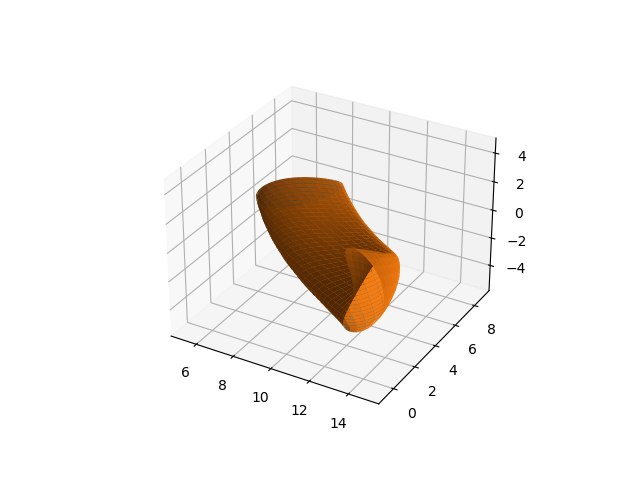

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
s.plot(ax=ax,show=False,close=True)
v.plot(ax=ax,show=False,close=True)
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)

In [12]:
# Define one WP on the WS
wp_order = 2
wp_qpts = 32

ncurves = 8
nfp = s.nfp
R0 = 1.35
R1 = 0.05
Z0 = 0.2
order = 1
#base_wp_curve = create_equally_spaced_windowpane_curves( ncurves, nfp, R0, R1,-Z0, order, numquadpoints=None ) +\
#    create_equally_spaced_windowpane_curves( ncurves, nfp, R0, R1,  0, order, numquadpoints=None )+\
#    create_equally_spaced_windowpane_curves( ncurves, nfp, R0, R1, Z0, order, numquadpoints=None )
c2d = []
base_wp_curve = []
tt = np.linspace(0,1,12,endpoint=False)
pp = np.linspace(0,1/(2*v.nfp),6,endpoint=False)
dt = tt[1]-tt[2]
dp = pp[1]-pp[2]
for it in tt:
    for ip in pp:
        c2d.append(
            Curve2D(wp_qpts, wp_order)
        )
        base_wp_curve.append(
            CurveCWSFourier(c2d[-1], v)
        )
        
        base_wp_curve[-1].curve2d.set('phic(0)', ip-dp/2.0)
        base_wp_curve[-1].curve2d.set('phic(1)', dp/3)
        base_wp_curve[-1].curve2d.set('thetac(0)', it)
        base_wp_curve[-1].curve2d.set('thetas(1)', dt/3)

# base_wp_curve = OrientedCurveXYZFourier(
#     wp_qpts, wp_order
# )
# base_wp_curve.set('x0',1.4)
# base_wp_curve.set('y0',0.25)
# base_wp_curve.set('z0',0.1)
# base_wp_curve.set('yc(1)',0.35)
# base_wp_curve.set('zs(1)',0.2)
# base_wp_curve.set('yaw', -0.35)
# base_wp_curve.unfix_all()

wp_curves = apply_symmetries_to_curves( base_wp_curve, s.nfp, True)
for c in wp_curves:
    c.fix_all()

base_wp_current = [ScaledCurrent(Current(0), 1e5) for c in base_wp_curve]
for c in base_wp_current:
    c.unfix_all()
wp_currents = apply_symmetries_to_currents( base_wp_current, s.nfp, True)

wp_coils = [Coil(curve, current) for curve, current in zip(wp_curves, wp_currents)]


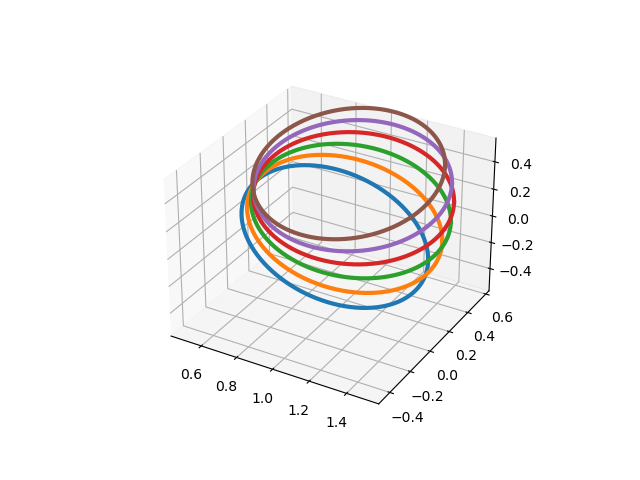

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for c in base_tf_curves:
    c.plot(ax=ax,show=False,linewidth=3)
for c in base_wp_curve:
    c.plot(ax=ax, color='b',linewidth=1,show=False)

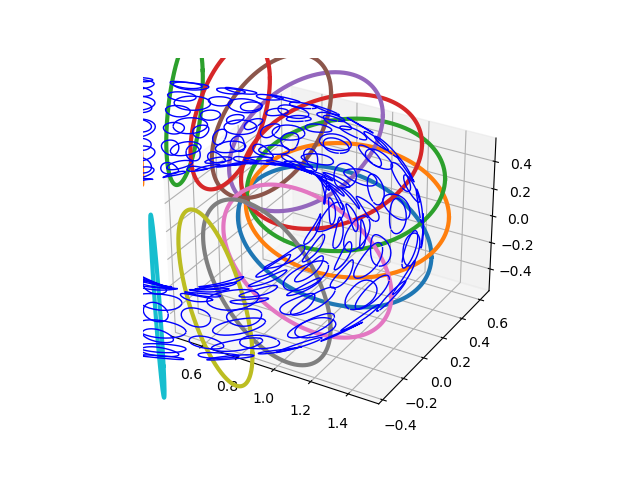

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#fulls.plot(ax=ax,show=False)
for c in tf_coils:
    c.curve.plot(ax=ax,show=False,linewidth=3)
for c in wp_coils:
    c.curve.plot(ax=ax, show=False, color='b',linewidth=1)

In [8]:
full_coils = tf_coils + wp_coils
full_curves = [c.curve for c in full_coils]

bs = BiotSavart(full_coils)
bs.set_points(s.gamma().reshape((-1, 3)))

curves_to_vtk(tf_curves, OUT_DIR + "tf_curves_init")
curves_to_vtk(wp_curves, OUT_DIR + "tf_curves_init")
pointData = {"B_N": np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)[:, :, None]}
s.to_vtk(OUT_DIR + "plasma_bnd_init", extra_data=pointData)

In [9]:
#Define one port
port_order = 2
port_qpts = 64

c2dport = Curve2D(port_qpts, port_order )
port_curve = CurveCWSFourier(
    c2dport,
    s
)
nfp = s.nfp
dphi = 1/(2*nfp) * 1/ncoils
iphi0 = 0
port_curve.curve2d.set('phic(0)', iphi0*dphi)
port_curve.curve2d.set('phic(1)', dphi/3.0)
port_curve.curve2d.set('thetac(0)', 0.0)
port_curve.curve2d.set('thetas(1)', 0.05)

Text(0, 0.5, 'z')

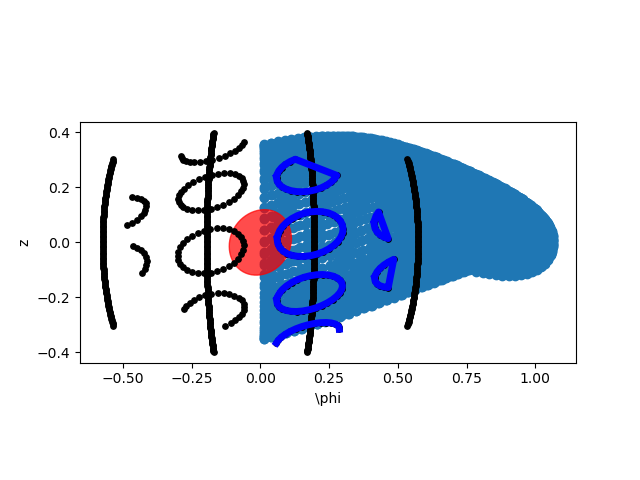

In [10]:
def project(x, x0):
    phic = np.arctan2(x0[1], x0[0])
    unit_normal = np.array([np.cos(phic), np.sin(phic), np.zeros(phic.shape)])
    unit_tangent = np.array([-np.sin(phic), np.cos(phic), np.zeros(phic.shape)])
    unit_z = np.array([np.zeros(phic.shape), np.zeros(phic.shape), np.ones(phic.shape)])

    M = np.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = np.linalg.inv(M)
    
    return np.einsum('ij,...j->...i',invM,x-x0)

x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in full_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

for c in base_wp_curve:
    gwp = project(c.gamma(), x0)
    zcurves = gwp[:,0]

    ind = np.where( zcurves>0 )[0]
    gwp = gwp[ind,:]
    ax.plot(gwp[:,1], gwp[:,2], color='b', linewidth=5)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [11]:
# Define the individual terms objective function:
## Quad flux and coil reguularization
Jf = SquaredFlux(s, bs)
Jls = [CurveLength(c) for c in base_tf_curves]
Jccdist = CurveCurveDistance(tf_curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(base_tf_curves, s, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_tf_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_tf_curves]
linkNum = LinkingNumber(base_tf_curves)

JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + QuadraticPenalty(linkNum, 0.1) 

# WS penalties
# Jl_wp = [CurveLength(base_wp_curve)]
# Jcs_wp = [LpCurveCurvature(base_wp_curve, 2, CURVATURE_THRESHOLD)]
# Jmscs_wp = [MeanSquaredCurvature(base_wp_curve)]
# Jwp = 1.0 * sum([QuadraticPenalty(jj, 1.0) for jj in Jl_wp]) \
#     + CURVATURE_WEIGHT * sum(Jcs_wp) \
#     + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs_wp) 
# JF += wp_weight * Jwp

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( port_curve, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( tf_curves, port_curve, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( port_curve, projection='zphi' )
Jarc = ArclengthVariation( port_curve )
Jufp = DirectedFacingPort(port_curve, projection='r')
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex

JF += wport * Jport

# Form the total objective function. To do this, we can exploit the
# fact that Optimizable objects with J() and dJ() functions can be
# multiplied by scalars and added:

#J= Jport

# We don't have a general interface in SIMSOPT for optimisation problems that
# are not in least-squares form, so we write a little wrapper function that we
# pass directly to scipy.optimize.minimize


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs.AbsB())

    
    A = Jxyarea.J()
    CC = Jccxydist.J()
    arc = Jarc.J()
    #convex = Jconvex.J()
    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_tf_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}\n"
    #outstr += f", Link Number = {linkNum.J()}\n"
    outstr += f"Jport={Jport.J():.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Arc penalty={arc:.2E}\n"#, Convex={convex:.2E}"
    print(outstr)
    return J, grad

Text(0.5, 0, '$\\theta$')

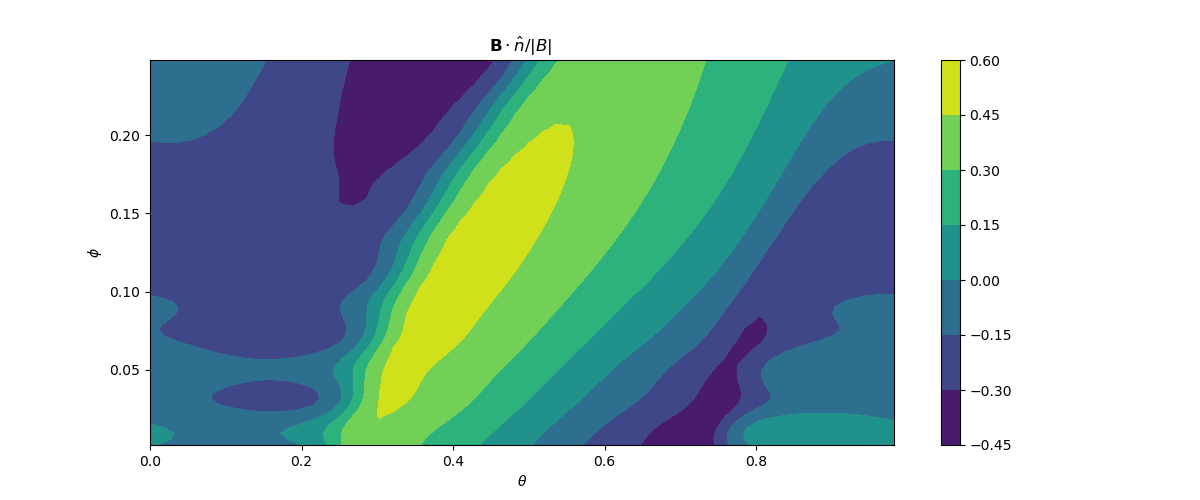

In [12]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(12,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [13]:
len(JF.dof_names)

357


################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=8.8e-02, Jf=7.3e-04, ⟨B·n⟩=1.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=18.8, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.13, C-S-Sep=0.11, ║∇J║=5.4e-01, ⟨B·n⟩/|B|=2.4e-01, (Max B·n)/|B|=6.8e-01
Jport=-2.10E-02, Area=2.10E-02, Coil-coil dist=0.00E+00, Arc penalty=1.33E-03

J=8.8e-02, Jf=7.3e-04, ⟨B·n⟩=1.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=18.8, ϰ=[2.5, 2.4, 2.6, 2.7, 2.6, 2.6], ∫ϰ²/L=[4.1, 4.0, 4.0, 4.1, 4.1, 4.1], C-C-Sep=0.13, C-S-Sep=0.11, ║∇J║=5.5e-01, ⟨B·n⟩/|B|=2.4e-01, (Max B·n)/|B|=6.8e-01
Jport=-2.20E-02, Area=2.20E-02, Coil-coil dist=0.00E+00, Arc penalty=1.34E-03

J=8.9e-02, Jf=7.3e-04, ⟨B·n⟩=1.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=18.9, ϰ=[2.5, 2.5, 2.5, 2.7, 2.6, 2.5], ∫

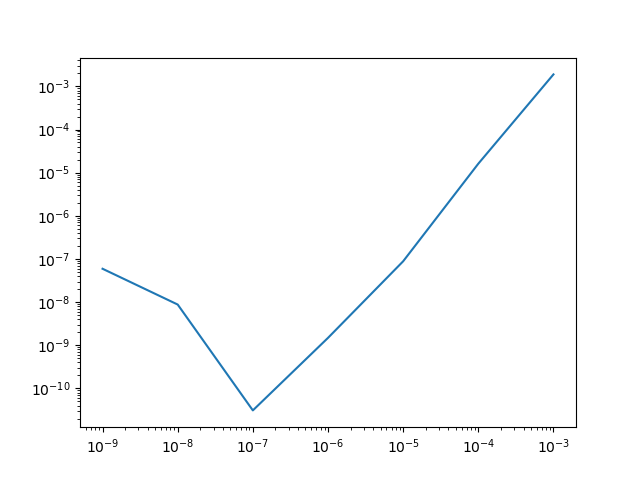

In [14]:
print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
myerr = []
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh)

plt.figure()
plt.loglog(myeps, np.abs(myerr))

In [15]:
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

J=8.8e-02, Jf=7.3e-04, ⟨B·n⟩=1.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=18.8, ϰ=[2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ∫ϰ²/L=[4.0, 4.0, 4.0, 4.0, 4.0, 4.0], C-C-Sep=0.13, C-S-Sep=0.11, ║∇J║=5.4e-01, ⟨B·n⟩/|B|=2.4e-01, (Max B·n)/|B|=6.8e-01
Jport=-2.10E-02, Area=2.10E-02, Coil-coil dist=0.00E+00, Arc penalty=1.33E-03

J=2.3e+00, Jf=1.4e-03, ⟨B·n⟩=8.7e-03, Len=sum([1.4, 1.7, 1.4, 1.3, 1.4, 1.4])=8.6, ϰ=[43.7, 80.0, 36.0, 25.0, 31.7, 42.2], ∫ϰ²/L=[105.3, 289.2, 78.6, 49.1, 66.2, 102.1], C-C-Sep=0.19, C-S-Sep=0.00, ║∇J║=1.4e+01, ⟨B·n⟩/|B|=3.1e-01, (Max B·n)/|B|=1.3e+01
Jport=-2.14E-02, Area=2.15E-02, Coil-coil dist=0.00E+00, Arc penalty=1.33E-03

J=6.9e-02, Jf=7.2e-04, ⟨B·n⟩=1.2e-02, Len=sum([3.1, 3.1, 3.1, 3.1, 3.1, 3.1])=18.4, ϰ=[2.3, 2.6, 2.3, 2.2, 2.2, 2.3], ∫ϰ²/L=[4.2, 4.2, 4.2, 4.2, 4.2, 4.2], C-C-Sep=0.13, C-S-Sep=0.11, ║∇J║=4.9e-01, ⟨B·n⟩/|B|=2.4e-01, (Max B·n)/|B|=6.8e-01
Jport=-2.10E-02, Area=2.11E-02, Coil-coil dist=0.00E+00, Arc penalty=1.33E-03

J=1.6e-01, Jf=5.8e-04, ⟨B·n⟩=1.0


################################################################################
### Perform a Taylor test ######################################################
################################################################################

J=5.0e-03, Jf=1.4e-06, ⟨B·n⟩=4.2e-04, Len=sum([3.1, 2.8, 2.6, 2.5, 2.3, 2.3])=15.6, ϰ=[14.8, 10.8, 8.5, 6.4, 5.4, 6.2], ∫ϰ²/L=[16.2, 12.4, 11.1, 11.2, 11.0, 11.6], C-C-Sep=0.11, C-S-Sep=0.13, ║∇J║=1.2e-04, ⟨B·n⟩/|B|=9.2e-03, (Max B·n)/|B|=6.2e-02
Jport=-8.31E-02, Area=8.31E-02, Coil-coil dist=0.00E+00, Arc penalty=9.75E-04

J=5.0e-03, Jf=1.4e-06, ⟨B·n⟩=4.3e-04, Len=sum([3.1, 2.8, 2.6, 2.5, 2.3, 2.3])=15.6, ϰ=[15.9, 9.3, 8.6, 6.1, 8.0, 6.6], ∫ϰ²/L=[16.8, 11.8, 11.1, 11.1, 11.6, 12.1], C-C-Sep=0.11, C-S-Sep=0.13, ║∇J║=1.2e-03, ⟨B·n⟩/|B|=9.5e-03, (Max B·n)/|B|=6.0e-02
Jport=-8.37E-02, Area=8.37E-02, Coil-coil dist=0.00E+00, Arc penalty=1.00E-03

J=3.6e-02, Jf=1.4e-06, ⟨B·n⟩=4.2e-04, Len=sum([3.1, 2.8, 2.6, 2.5, 2.3, 2.3])=15.6, ϰ=[13.7, 12.8, 8.5, 

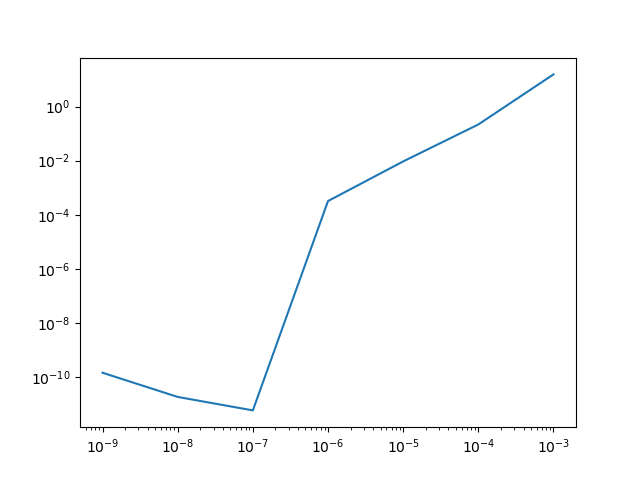

In [16]:
print("""
################################################################################
### Perform a Taylor test ######################################################
################################################################################
""")
f = fun
dofs = JF.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
myerr = []
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh)

plt.figure()
plt.loglog(myeps, np.abs(myerr))

In [17]:
print(res.message)

ABNORMAL_TERMINATION_IN_LNSRCH


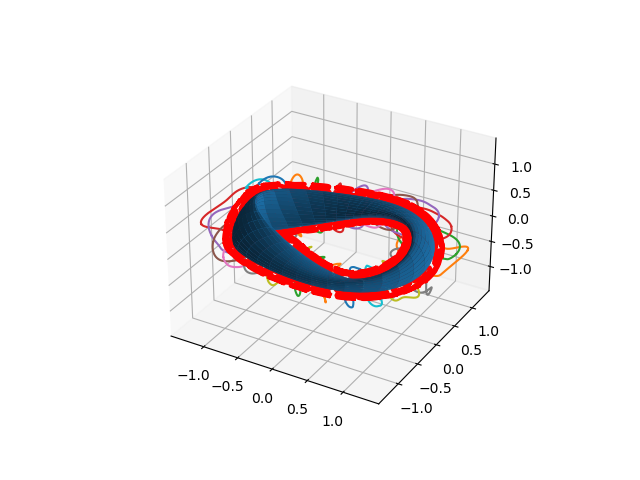

In [18]:
fulls.plot(show=False, close=True)
ax = plt.gca()
for c in tf_curves:
    c.plot(ax=ax, show=False)
for c in wp_curves:
    c.plot(ax=ax, show=False, color='r', linewidth=3)

Text(0.5, 0, '$\\theta$')

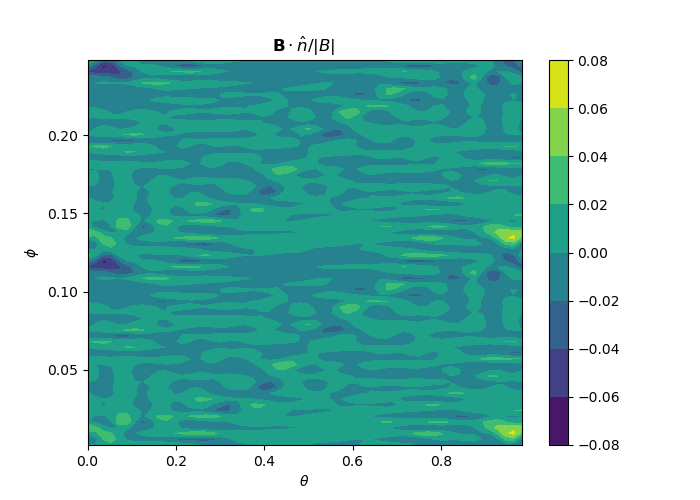

In [19]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

Text(0, 0.5, 'z')

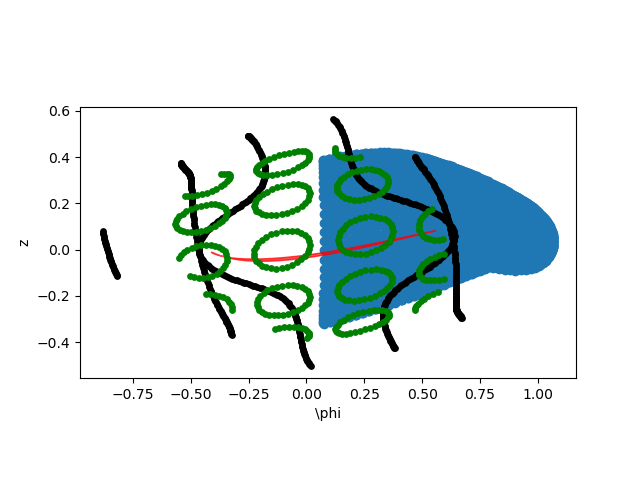

In [20]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in tf_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)
for c in wp_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='g', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [22]:
Jxyarea.J()

Array(0.08309199, dtype=float64)

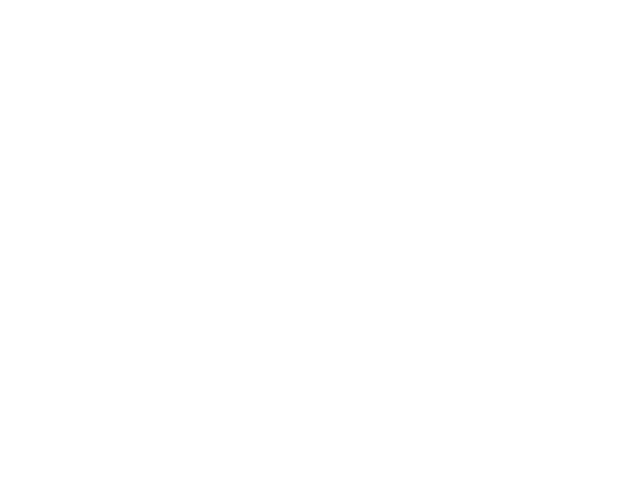

In [21]:
# Run and plot Poincare section
surf = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1 = SurfaceRZFourier.from_vmec_input(filename, range="half period", nphi=nphi, ntheta=ntheta)
surf1.extend_via_normal(0.1)
nfp = surf.nfp

Rmaj = surf.major_radius()
r0 = surf.minor_radius()
#sc_fieldline = SurfaceClassifier(surf1, h=0.01, p=3)
nfieldlines = 20
tmax_fl = 2500
degree = 4

def trace_fieldlines(bfield,label):
    # Set up initial conditions - 
    R0 = np.linspace(1.15,1.25, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis)#, stopping_criteria=[LevelsetStoppingCriterion(sc_fieldline.dist)])
    plot_poincare_data(fieldlines_phi_hits, phis, 'poincare_final', dpi=150,surf=surf,mark_lost=True)
    return fieldlines_phi_hits

hits = trace_fieldlines(bs, 'vmec')

# Delete non-used coils

In [33]:
ind

array([ 10,  11,  15,  20,  22,  25,  27,  30,  31,  36,  82,  83,  87,
        92,  94,  97,  99, 102, 103, 108, 154, 155, 159, 164, 166, 169,
       171, 174, 175, 180, 226, 227, 231, 236, 238, 241, 243, 246, 247,
       252, 298, 299, 303, 308, 310, 313, 315, 318, 319, 324, 370, 371,
       375, 380, 382, 385, 387, 390, 391, 396, 442, 443, 447, 452, 454,
       457, 459, 462, 463, 468, 514, 515, 519, 524, 526, 529, 531, 534,
       535, 540])

In [40]:
cvalues = np.array([np.abs(c.current.get_value()) for c in wp_coils])
ind = np.where(cvalues>5e2)[0]
wp_coils_reduced = [wp_coils[ii] for ii in ind]
coils_reduced = tf_coils + wp_coils_reduced

bs_reduced = BiotSavart(coils_reduced)

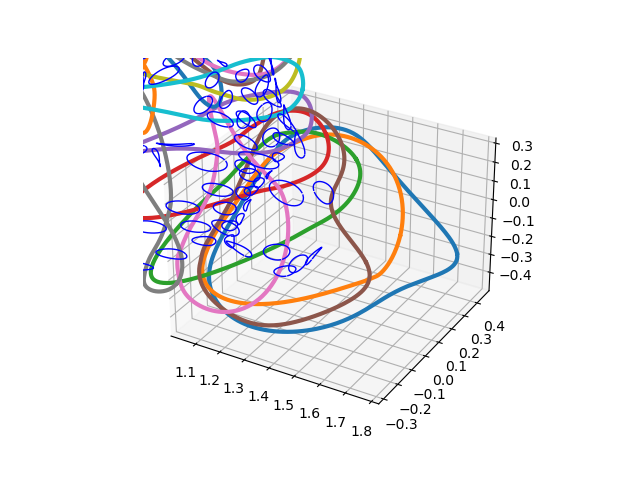

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#fulls.plot(ax=ax,show=False)
for c in tf_coils:
    c.curve.plot(ax=ax,show=False,linewidth=3)
for c in wp_coils_reduced:
    c.curve.plot(ax=ax, show=False, color='b',linewidth=1)

Text(0.5, 0, '$\\theta$')

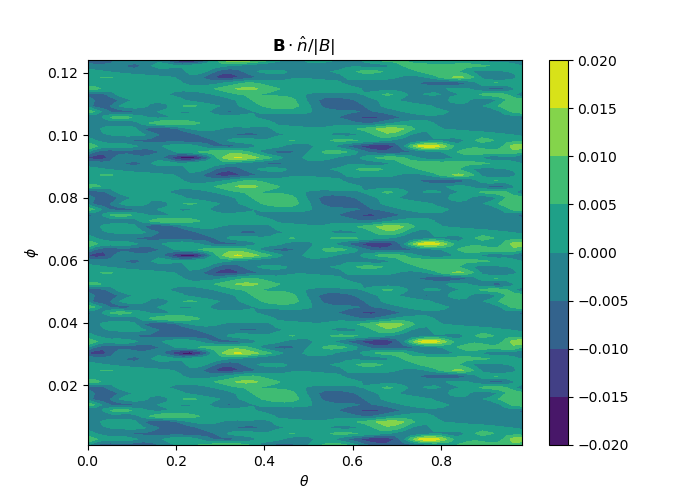

In [42]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs_reduced.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs_reduced.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs_reduced.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

In [50]:
bs_reduced.set_points(s.gamma().reshape((-1,3)))

Jf = SquaredFlux(s, bs_reduced)
Jls = [CurveLength(c) for c in base_tf_curves]
Jccdist = CurveCurveDistance(tf_curves, CC_THRESHOLD, num_basecurves=ncoils)
Jcsdist = CurveSurfaceDistance(base_tf_curves, s, CS_THRESHOLD)
Jcs = [LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_tf_curves]
Jmscs = [MeanSquaredCurvature(c) for c in base_tf_curves]
linkNum = LinkingNumber(base_tf_curves)

JF = Jf \
    + LENGTH_WEIGHT * QuadraticPenalty(sum(Jls), 2.6*ncoils) \
    + CC_WEIGHT * Jccdist \
    + CS_WEIGHT * Jcsdist \
    + CURVATURE_WEIGHT * sum(Jcs) \
    + MSC_WEIGHT * sum(QuadraticPenalty(J, MSC_THRESHOLD) for J in Jmscs) \
    + QuadraticPenalty(linkNum, 0.1) 

# Port relavant penalties
Jxyarea = ProjectedEnclosedArea( port_curve, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( tf_curves, port_curve, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( port_curve, projection='zphi' )
Jarc = ArclengthVariation( port_curve )
Jufp = DirectedFacingPort(port_curve, projection='r')
Jport = -1 * Jxyarea + wdd * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex

JF += wport * Jport


def fun(dofs):
    JF.x = dofs
    J = JF.J()
    grad = JF.dJ()
    jf = Jf.J()
    BdotN = np.mean(np.abs(np.sum(bs_reduced.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    MaxBdotN = np.max(np.abs(np.sum(bs_reduced.B().reshape((nphi, ntheta, 3)) * s.unitnormal(), axis=2)))
    mean_AbsB = np.mean(bs_reduced.AbsB())

    
    A = Jxyarea.J()
    CC = Jccxydist.J()
    arc = Jarc.J()
    
    outstr = f"J={J:.1e}, Jf={jf:.1e}, ⟨B·n⟩={BdotN:.1e}"
    cl_string = ", ".join([f"{J.J():.1f}" for J in Jls])
    kap_string = ", ".join(f"{np.max(c.kappa()):.1f}" for c in base_tf_curves)
    msc_string = ", ".join(f"{J.J():.1f}" for J in Jmscs)
    outstr += f", Len=sum([{cl_string}])={sum(J.J() for J in Jls):.1f}, ϰ=[{kap_string}], ∫ϰ²/L=[{msc_string}]"
    outstr += f", C-C-Sep={Jccdist.shortest_distance():.2f}, C-S-Sep={Jcsdist.shortest_distance():.2f}"
    outstr += f", ║∇J║={np.linalg.norm(grad):.1e}"
    outstr += f", ⟨B·n⟩/|B|={BdotN/mean_AbsB:.1e}"
    outstr += f", (Max B·n)/|B|={MaxBdotN/mean_AbsB:.1e}\n"
    #outstr += f", Link Number = {linkNum.J()}\n"
    outstr += f"Jport={Jport.J():.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Arc penalty={arc:.2E}\n"#, Convex={convex:.2E}"
    print(outstr)
    return J, grad

In [51]:
dofs = JF.x
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

J=5.0e-03, Jf=2.9e-07, ⟨B·n⟩=2.4e-04, Len=sum([2.9, 2.6, 2.6, 2.4, 2.5])=13.0, ϰ=[8.3, 11.3, 8.9, 6.3, 6.6], ∫ϰ²/L=[12.6, 11.2, 11.7, 11.3, 11.0], C-C-Sep=0.08, C-S-Sep=0.12, ║∇J║=3.1e-04, ⟨B·n⟩/|B|=3.7e-03, (Max B·n)/|B|=1.7e-02
Jport=-9.92E-03, Area=9.97E-03, Coil-coil dist=4.69E-17, Arc penalty=4.65E-03

J=4.5e+01, Jf=1.7e-03, ⟨B·n⟩=1.9e-02, Len=sum([8.0, 5.3, 5.7, 5.3, 5.8])=30.1, ϰ=[56.8, 14.5, 615.1, 91.5, 34.9], ∫ϰ²/L=[34.9, 19.0, 317.6, 47.1, 34.9], C-C-Sep=0.00, C-S-Sep=0.10, ║∇J║=3.2e+03, ⟨B·n⟩/|B|=2.6e-01, (Max B·n)/|B|=3.2e+00
Jport=3.11E+05, Area=7.97E-03, Coil-coil dist=3.11E-03, Arc penalty=7.59E-03

J=5.0e-03, Jf=2.9e-07, ⟨B·n⟩=2.4e-04, Len=sum([2.9, 2.6, 2.6, 2.4, 2.5])=13.0, ϰ=[8.3, 11.3, 8.9, 6.3, 6.6], ∫ϰ²/L=[12.6, 11.2, 11.7, 11.3, 11.0], C-C-Sep=0.08, C-S-Sep=0.12, ║∇J║=2.6e-04, ⟨B·n⟩/|B|=3.7e-03, (Max B·n)/|B|=1.7e-02
Jport=-9.92E-03, Area=9.97E-03, Coil-coil dist=0.00E+00, Arc penalty=4.65E-03

J=5.0e-03, Jf=2.9e-07, ⟨B·n⟩=2.4e-04, Len=sum([2.9, 2.6, 2.6, 2.4, 2

Text(0.5, 0, '$\\theta$')

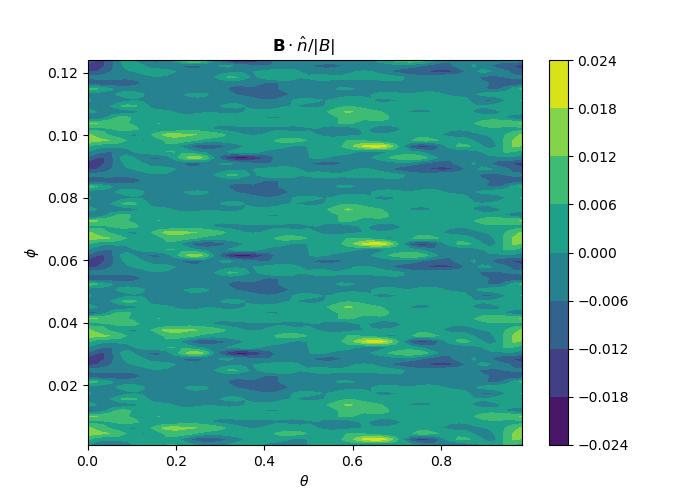

In [52]:
surf = s
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(fulls.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * fulls.unitnormal(), axis=2)
modB = bs.AbsB().reshape((nphi,ntheta))

fig, ax = plt.subplots(figsize=(7,5))
c = ax.contourf(theta,phi,Bdotn / modB)
plt.colorbar(c)
ax.set_title(r'$\mathbf{B}\cdot\hat{n} / |B|$ ')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')

Text(0, 0.5, 'z')

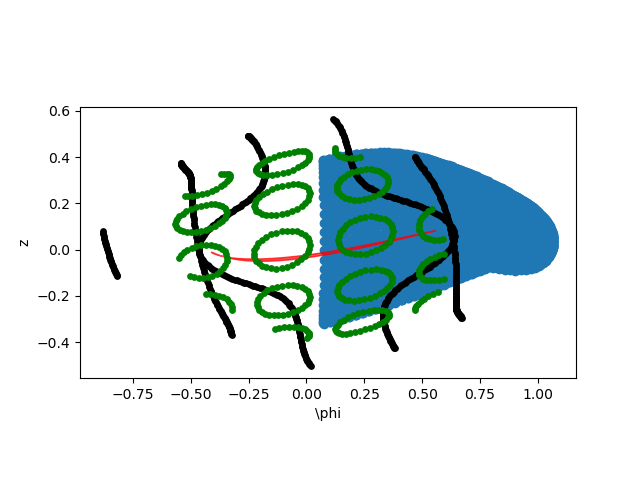

In [23]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in tf_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)
for c in wp_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='g', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

# Recompute the port

In [24]:
# =============================================================================

In [32]:
#Define one port
port_order = 2
port_qpts = 128

c2dport = Curve2D(port_qpts, port_order )
port_curve = CurveCWSFourier(
    c2dport,
    fulls
)
nfp = s.nfp
dphi = 1/(2*nfp) * 1/ncoils
iphi0 = 0
port_curve.curve2d.set('phic(0)', iphi0*dphi)
port_curve.curve2d.set('phic(1)', dphi/3.0)
port_curve.curve2d.set('thetac(0)', 0.0)
port_curve.curve2d.set('thetas(1)', 0.05)

for c in base_tf_curves: 
    c.fix_all()
for c in base_tf_currents:
    c.fix_all()
for c in base_wp_curve:
    c.fix_all()
for c in base_wp_current:
    c.fix_all()

surf.fix_all()

Jxyarea = ProjectedEnclosedArea( port_curve, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( tf_curves, port_curve, 0.05, projection='zphi' )
Jconvex = ProjectedCurveConvexity( port_curve, projection='zphi' )
Jarc = ArclengthVariation( port_curve )
Jufp = DirectedFacingPort(port_curve, projection='r')
Jport = -1 * Jxyarea + wdd/100 * Jccxydist + warc * Jarc + wufp * Jufp #+ wco * Jconvex


def fun(dofs):
    Jport.x = dofs
    return Jport.J(), Jport.dJ()


In [33]:
dofs = Jport.x

MAXITER = 1E3
res = minimize(fun, dofs, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER}, tol=1e-12)

Text(0, 0.5, 'z')

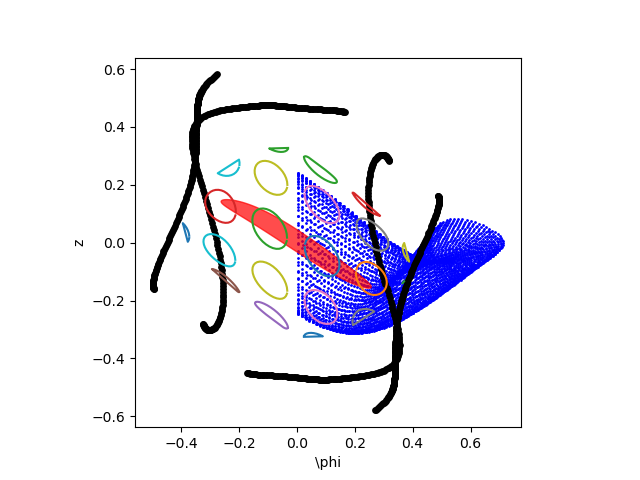

In [34]:
x0 = np.mean(port_curve.gamma(),axis=0)
gproj = project(s.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2],color='b',s=1)

gport = project(port_curve.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in tf_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)
for c in wp_curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.plot(g[:,1], g[:,2])

ax.set_aspect('equal')
ax.set_xlabel('\phi')
ax.set_ylabel('z')

In [35]:
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk
from simsopt.geo import curves_to_vtk

mydir = 'stage_II_with_wps'
full_port  = apply_symmetries_to_curves( [port_curve], s.nfp, True)
curves_to_vtk(full_port, os.path.join(mydir, 'port_final'))
surf_to_vtk(os.path.join(mydir, 'final_plasma_boundary'), bs, fulls)
coils_to_vtk( tf_coils, os.path.join(mydir, 'final_tf_coils'))
coils_to_vtk( wp_coils, os.path.join(mydir, 'final_wp_coils'))


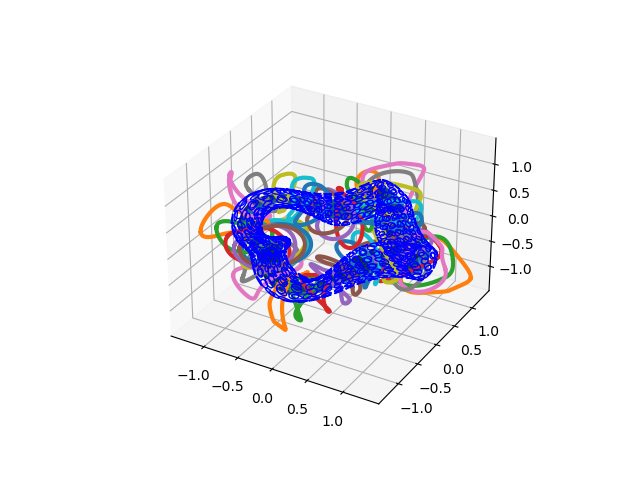

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fulls.plot(ax=ax,show=False)
for c in tf_coils:
    c.curve.plot(ax=ax,show=False,linewidth=3)
for c in wp_coils:
    c.curve.plot(ax=ax, show=False, color='b',linewidth=1)